<b>Exercise and Non-Exercise Predictors of Heart Disease</b>

Heart disease (HD) has many symptoms, thus, diagnosis is difficult, and it is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). We want to determine whether exercise-induced parameters can more accurately diagnose HD than non-exercise-related predictors. We will create one model classifying non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression during exercise, angina during exercise, and slope (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0 to 4 (Detrano, n.d.).

We tidied the data to create our datasets from the processed.cleveland.data file (Detrano, n.d.). Our first dataset includes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as in many experiments its correlation to HD has been identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of the most important risk factors for cardiovascular disease” (Wu et al., 2015). Our second dataset includes exercise-related predictors. ST depression during exercise is used as it is related to HD outcome, thus having medical value (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study the involvement of exercise testing for HD predictions, correlating to the extent of illness (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis. We will perform a $K$-nearest neighbors classification, using tidymodels, splitting 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data to build accurate models (Timbers et al., 2022). We will set a seed so our analysis is reproducible (Timbers et al., 2022) and “scale and center our data” (Timbers et al., 2022) to create a model. This requires cross-validation to determine each dataset’s optimal $K$, then our model will be fit to the testing data to classify the patients by diagnosis (Timbers et al., 2022). Our goal is determining the most accurate model, evaluating the metrics and confusion matrix for each (Timbers et al., 2022). To visualize our results we will create a bar plot denoting the number of correct/incorrect predictions in the testing dataset for each model to determine their accuracy.  

In conclusion, we are determining whether exercise or non-exercise predictors are more effective at diagnosing HD. We expect that having patients exercise before diagnosis will be a more effective strategy than without analyzing physical effort. This can impact diagnostic accuracy, by expanding our range of diagnostic tests. While it could be more time-consuming than traditional methods, and unrealistic in extreme situations, it could lead to questioning how we can apply the most appropriate diagnostic method in all patient circumstances. 



In [12]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [13]:
# Installation of the required libraries to conduct our data analysis.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(9999)

In [14]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


WRANGLING THE DATA:

In [15]:
# Set the dataset's column names to the factor descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

Creating the desired data frames and visualizing our data in tables with the mean of each variable.

In [16]:
# Mutate the result column into a factor, so it can be used to color and fill the graphs.
cleveland_data <- mutate(cleveland_data, result = as_factor(result))

# Wrangling the data by creating the desired datasets.
# Group 1: data collected from patients in resting state.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Group 2: data collected from patients after exercise.
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

head(cleveland_data_resting)
head(cleveland_data_exercise)

# We will use map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.
cleveland_data_resting_mean <- map_df(cleveland_data_resting, mean)
cleveland_data_exercise_mean <- map_df(cleveland_data_exercise, mean)
cleveland_data_resting_mean
cleveland_data_exercise_mean

age,resting_blood_pressure,resting_electrocardio,result
<dbl>,<dbl>,<dbl>,<fct>
63,145,2,0
67,160,2,2
67,120,2,1
37,130,0,0
41,130,2,0
56,120,0,0


exercise_angina,exercise_st,exercise_slope,result
<dbl>,<dbl>,<dbl>,<fct>
0,2.3,3,0
1,1.5,2,2
1,2.6,2,1
0,3.5,3,0
0,1.4,1,0
0,0.8,1,0


Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,resting_blood_pressure,resting_electrocardio,result
<dbl>,<dbl>,<dbl>,<dbl>
54.43894,131.6898,0.990099,NA


exercise_angina,exercise_st,exercise_slope,result
<dbl>,<dbl>,<dbl>,<dbl>
0.3267327,1.039604,1.60066,NA


For our tables, we chose to make an initial table that displays each data frame with the first six rows. We did this in order to be able to visualize the data that we have, including the possible values that each variable can adopt. Additionally, we computed the mean values for each of the columns. This allows us to have an understanding of the scope of the values for each of the columns. Since we see a very large disparity in some of the mean values, this tells us that we will have to scale the variables in our final model.


SPLITTING INTO TRAINING/TESTING:

In [17]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

VISUALIZING THE DATA:

As some of our predictors are binary while others have a large variety of values, we decided to visualize our graphs in the form of histograms, with the predictor values along the x-axis and number of diagnoses across the values of each predictor along the y-axis. The Heart Disease Status ranges from 0-4, with 0 indicating no evidence of heart disease and 4 depicting a severe diagnosis of heart disease.

- Fig. 1: A histogram to visualize the number of patients of different ages, and their diagnosis.
- Fig. 2: A histogram to visualize the number of patients with various resting blood pressures (in mm Hg), and the extent of the disease.
- Fig. 3: A histogram to visualize the number of patients belonging to each of the three resting electrocardiogram statuses, correlating to their heart disease status.


GROUP 1 GRAPHS:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



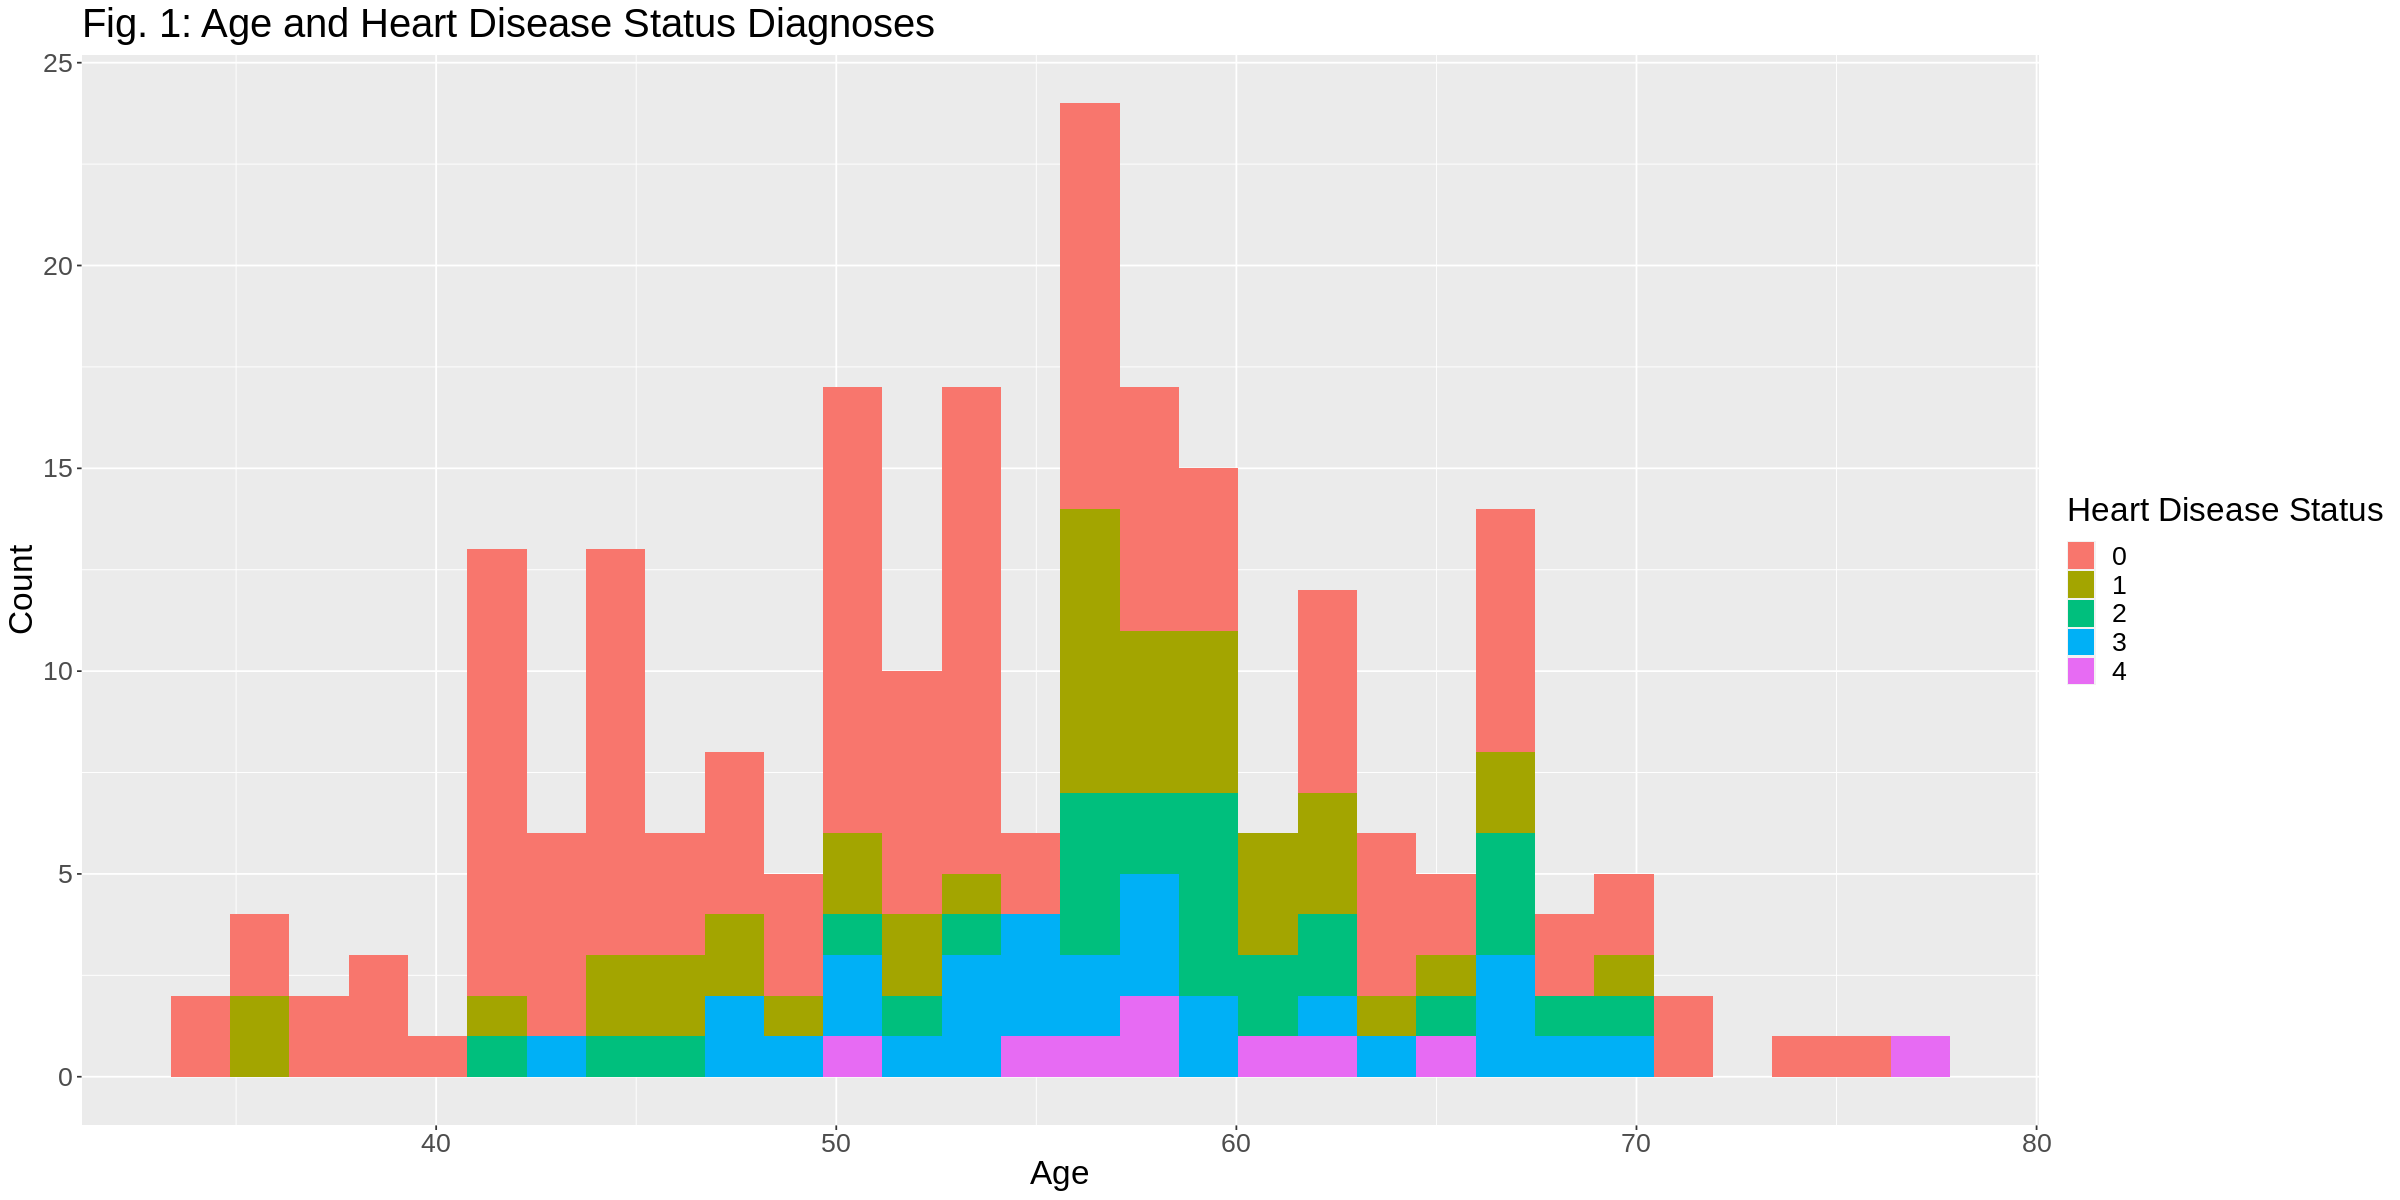

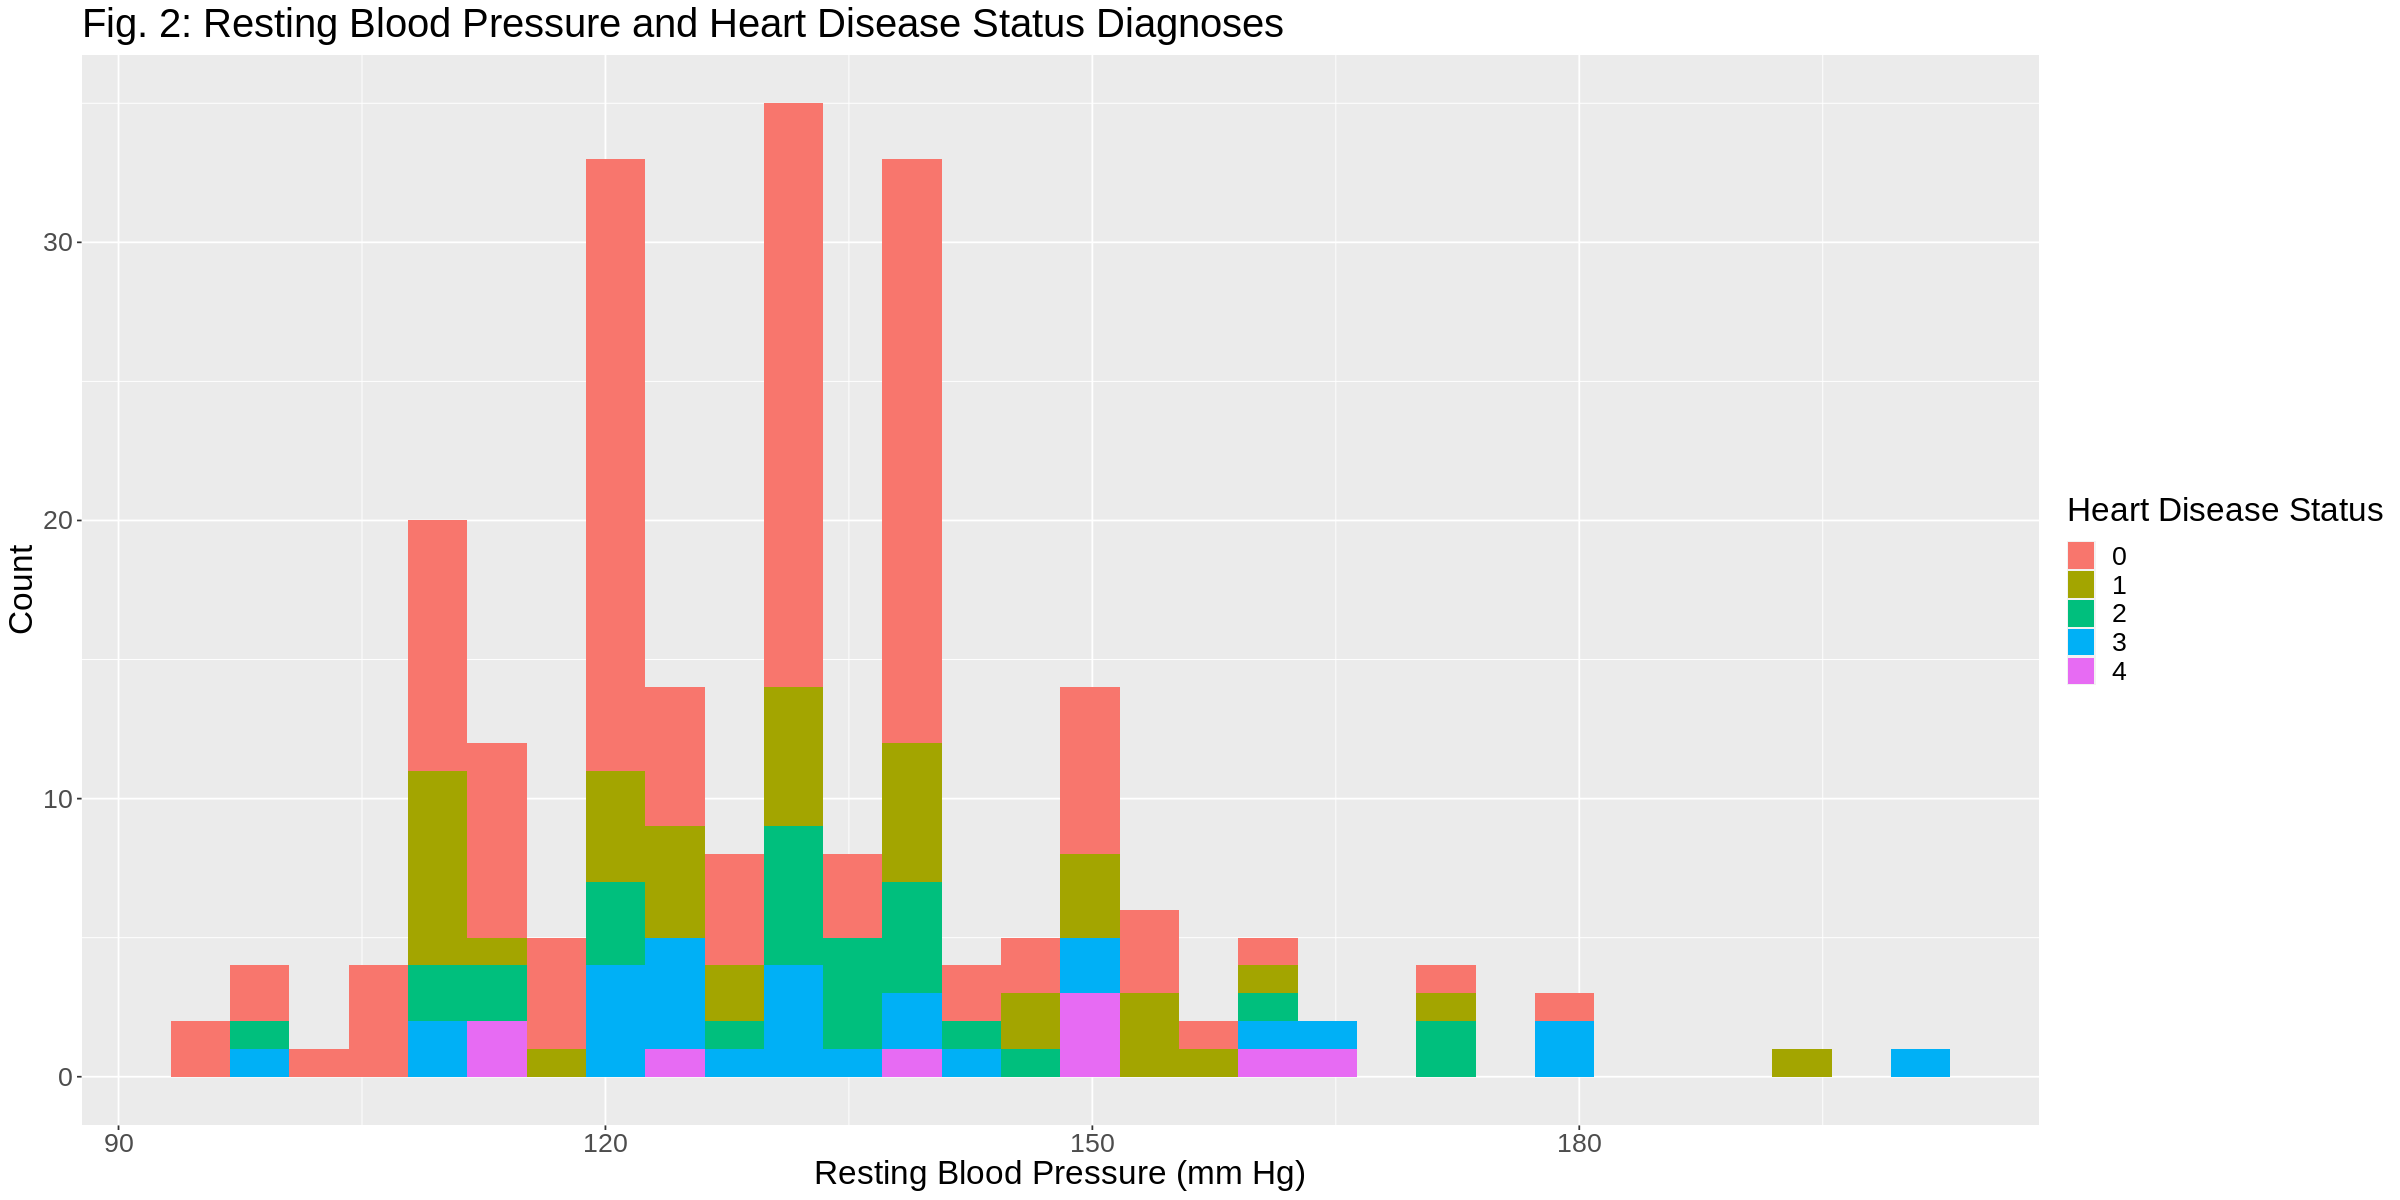

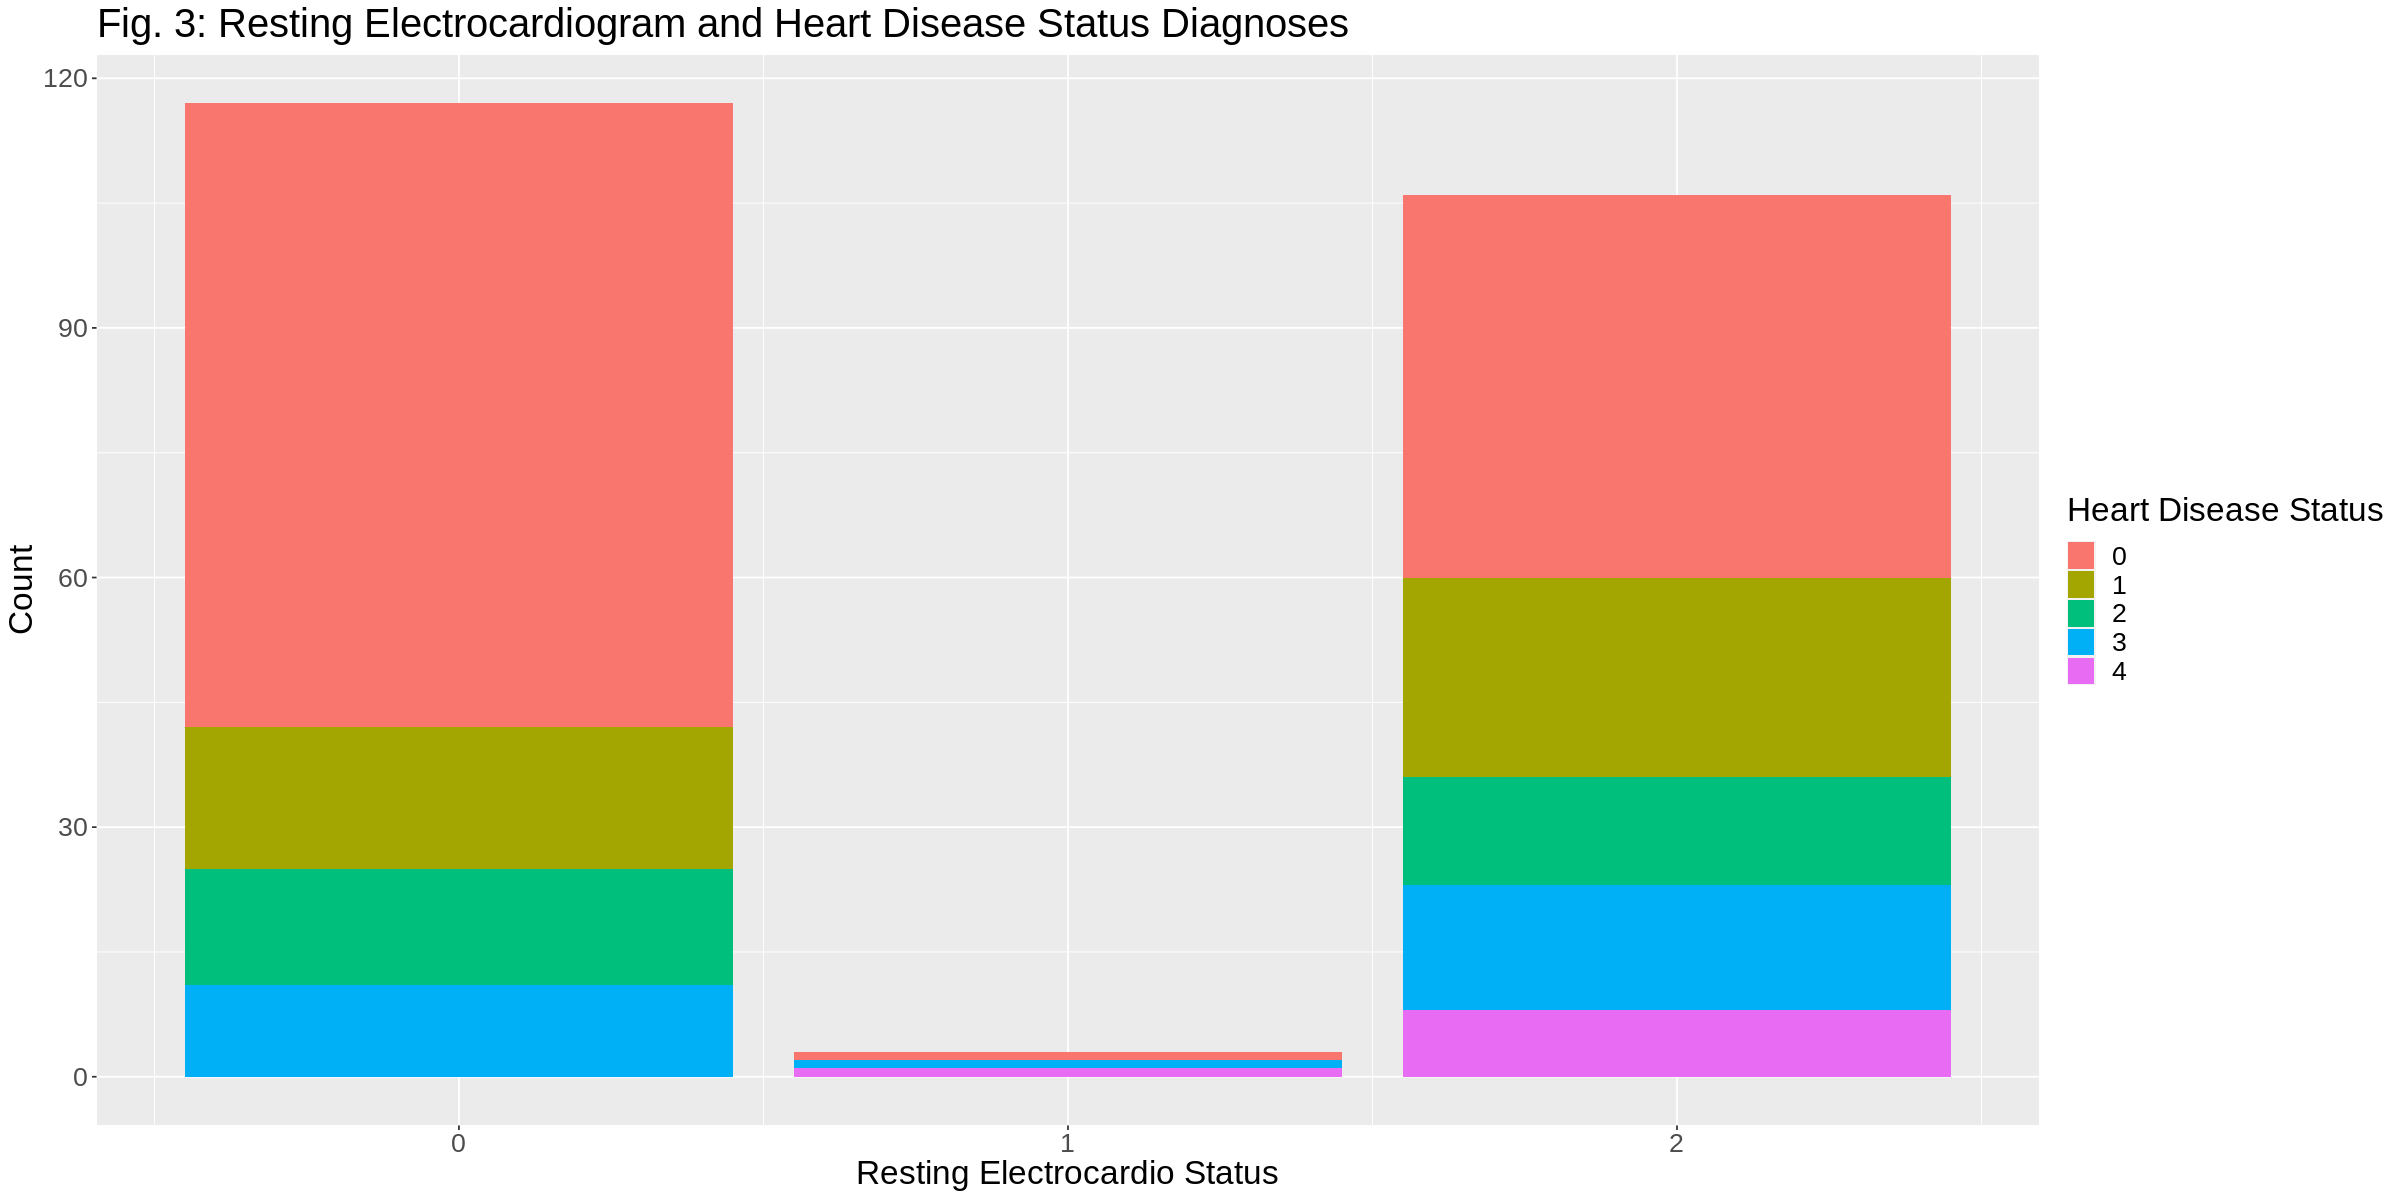

In [18]:
#Creating the plots to visualize the data in our first group of predictors in relation to the severity of heart disease. 
options(repr.plot.width = 20, repr.plot.height = 10) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_age_plot

resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_bps_plot

resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
    ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Resting Electrocardio Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_electro_plot

GROUP 2 GRAPHS:

- Fig. 4: A histogram to visualize the angine during exercise value related to the severity of heart disease.
- Fig. 2: A histogram to visualize the exercise-induced ST depression related to the heart disease severity. 
- Fig. 3: A histogram to visualize the slope during exercise testing and the heart disease status. 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



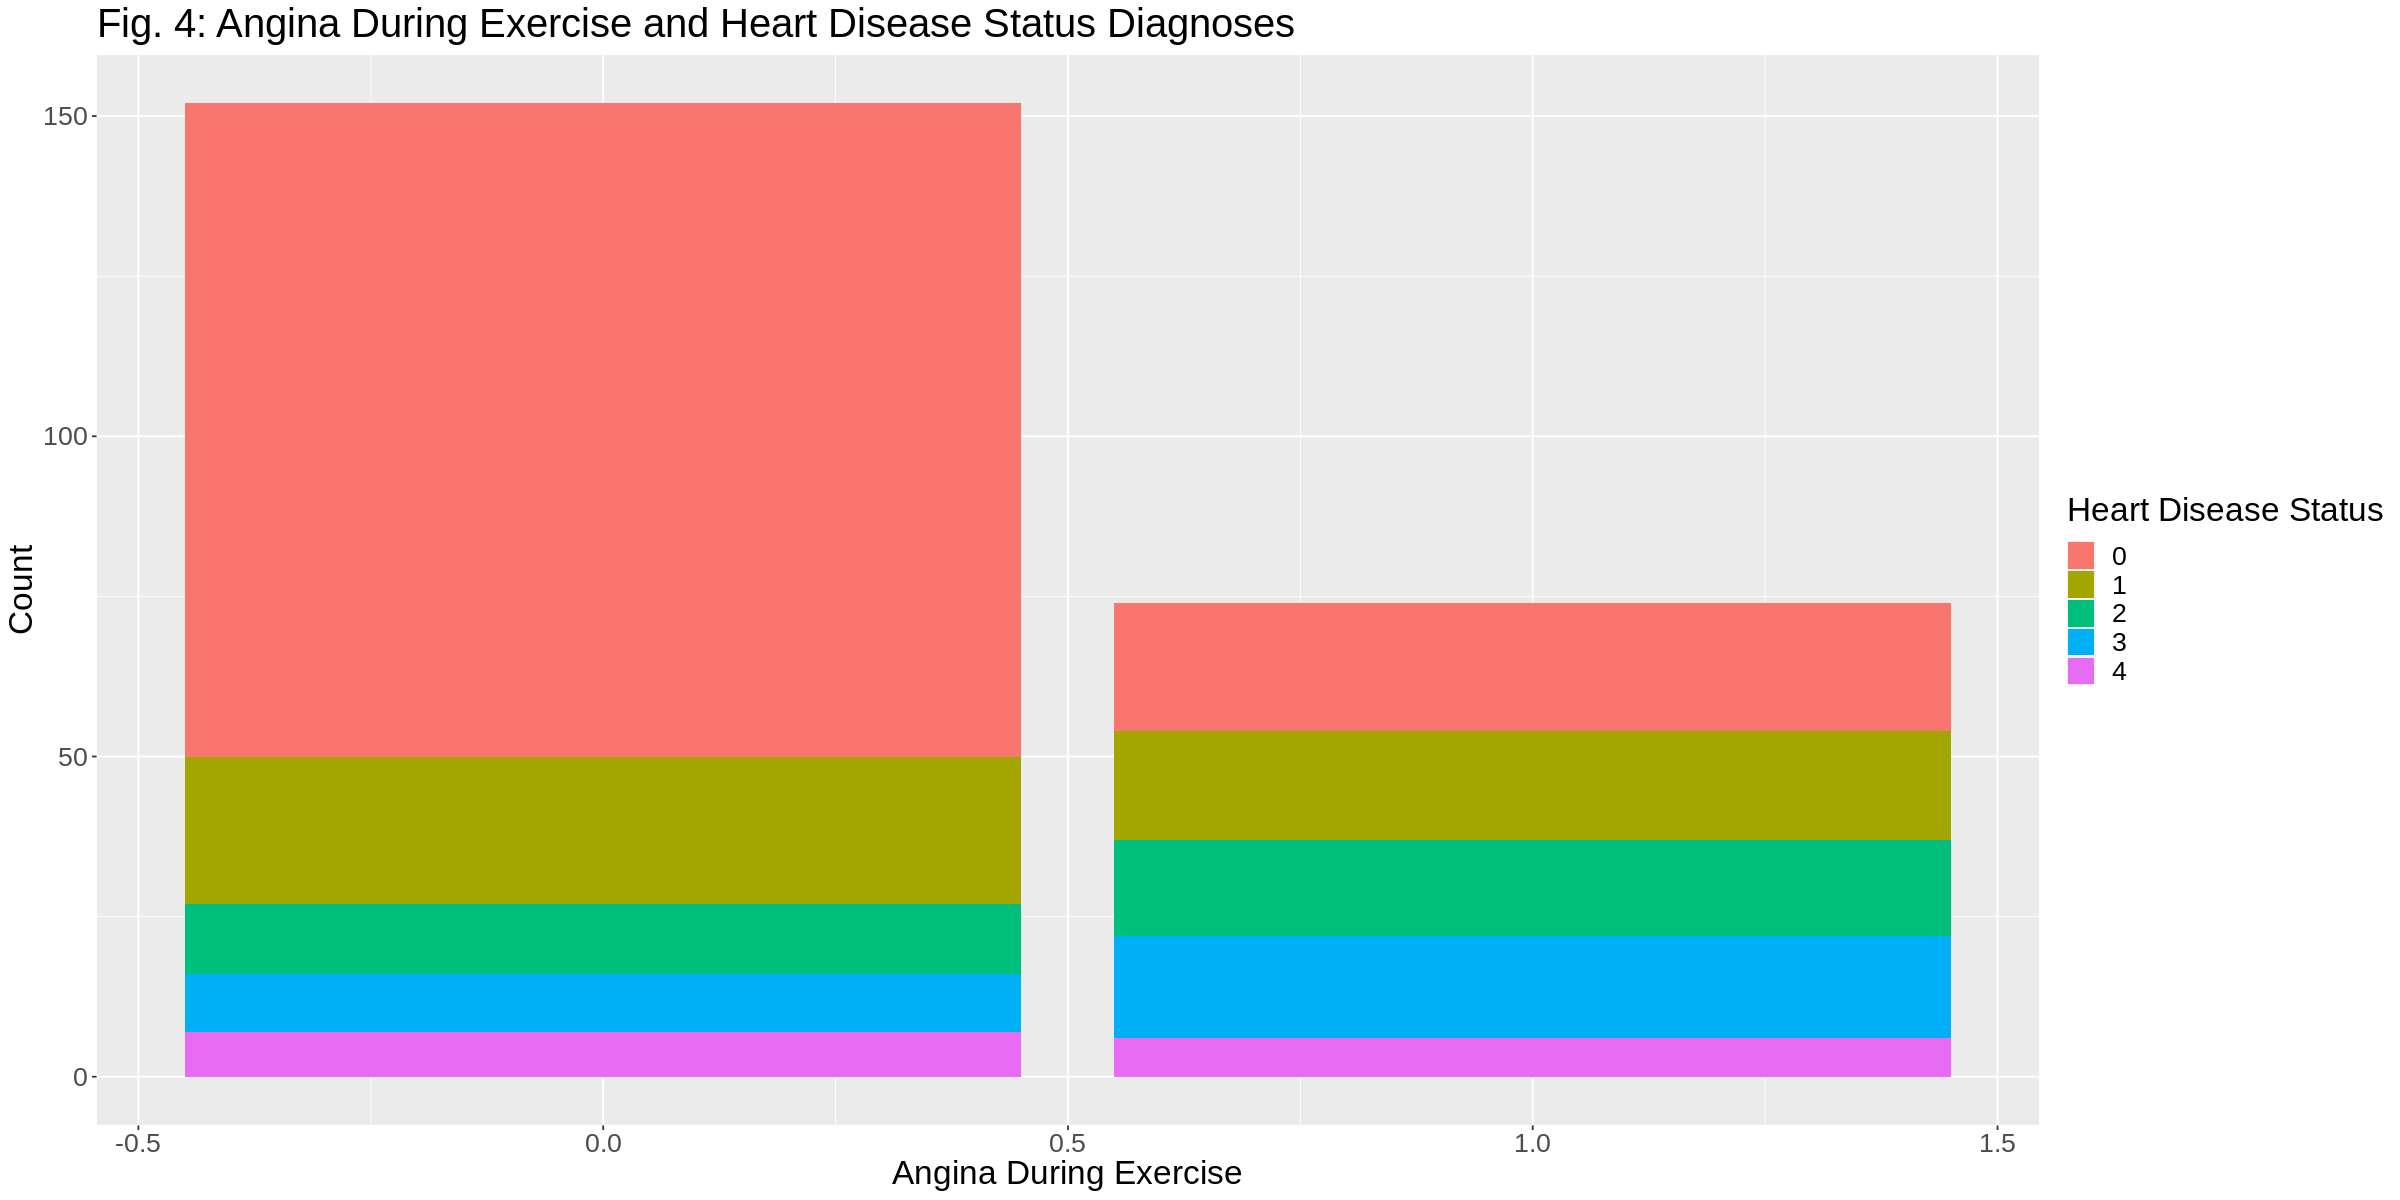

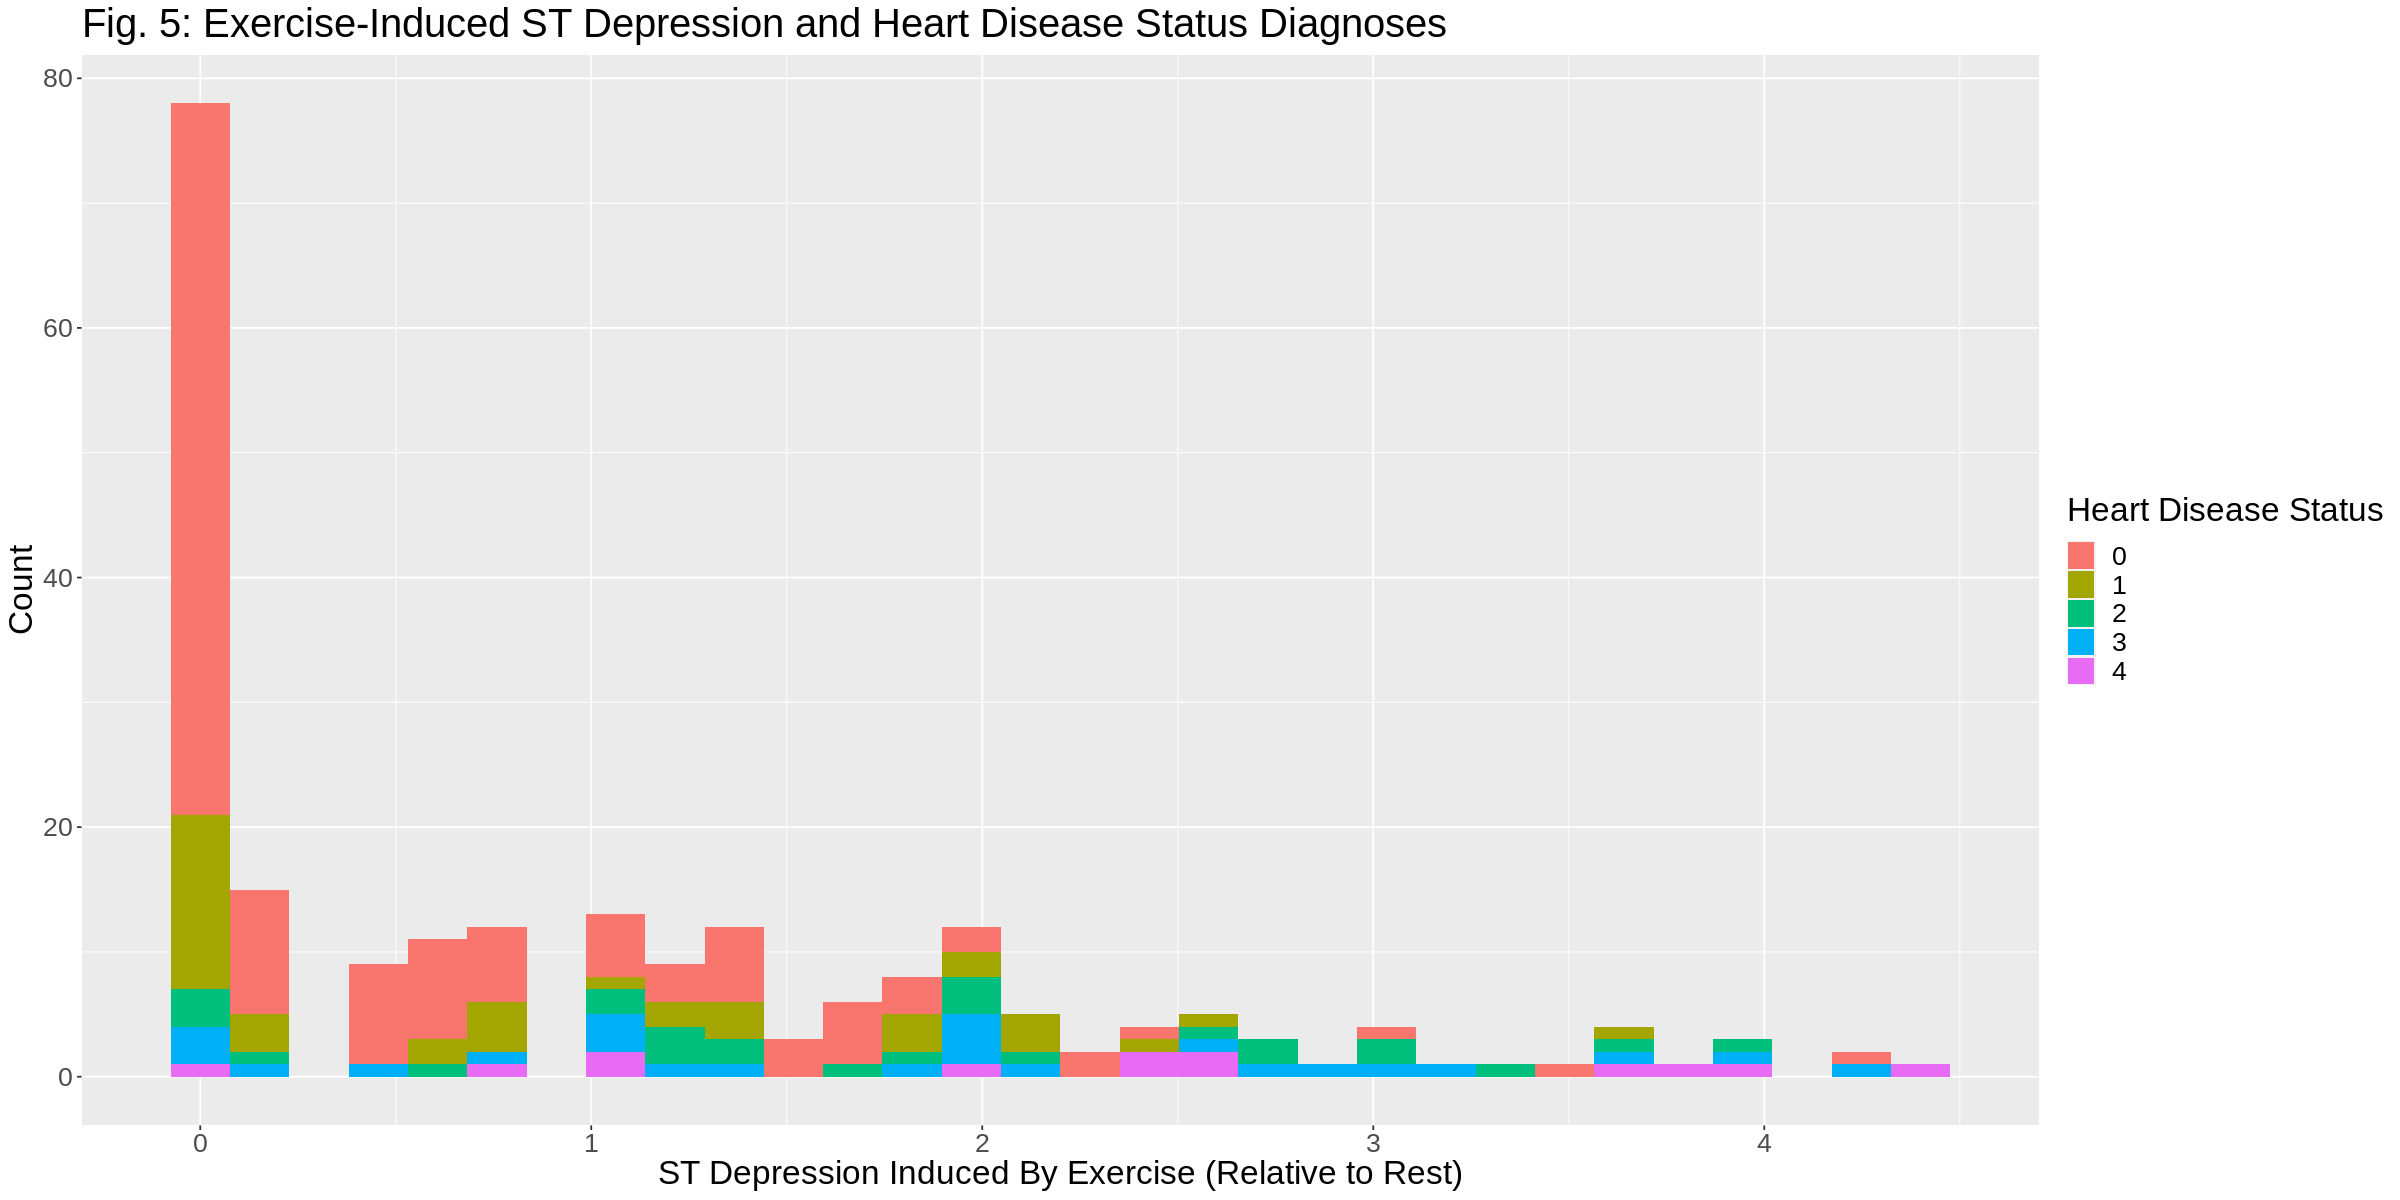

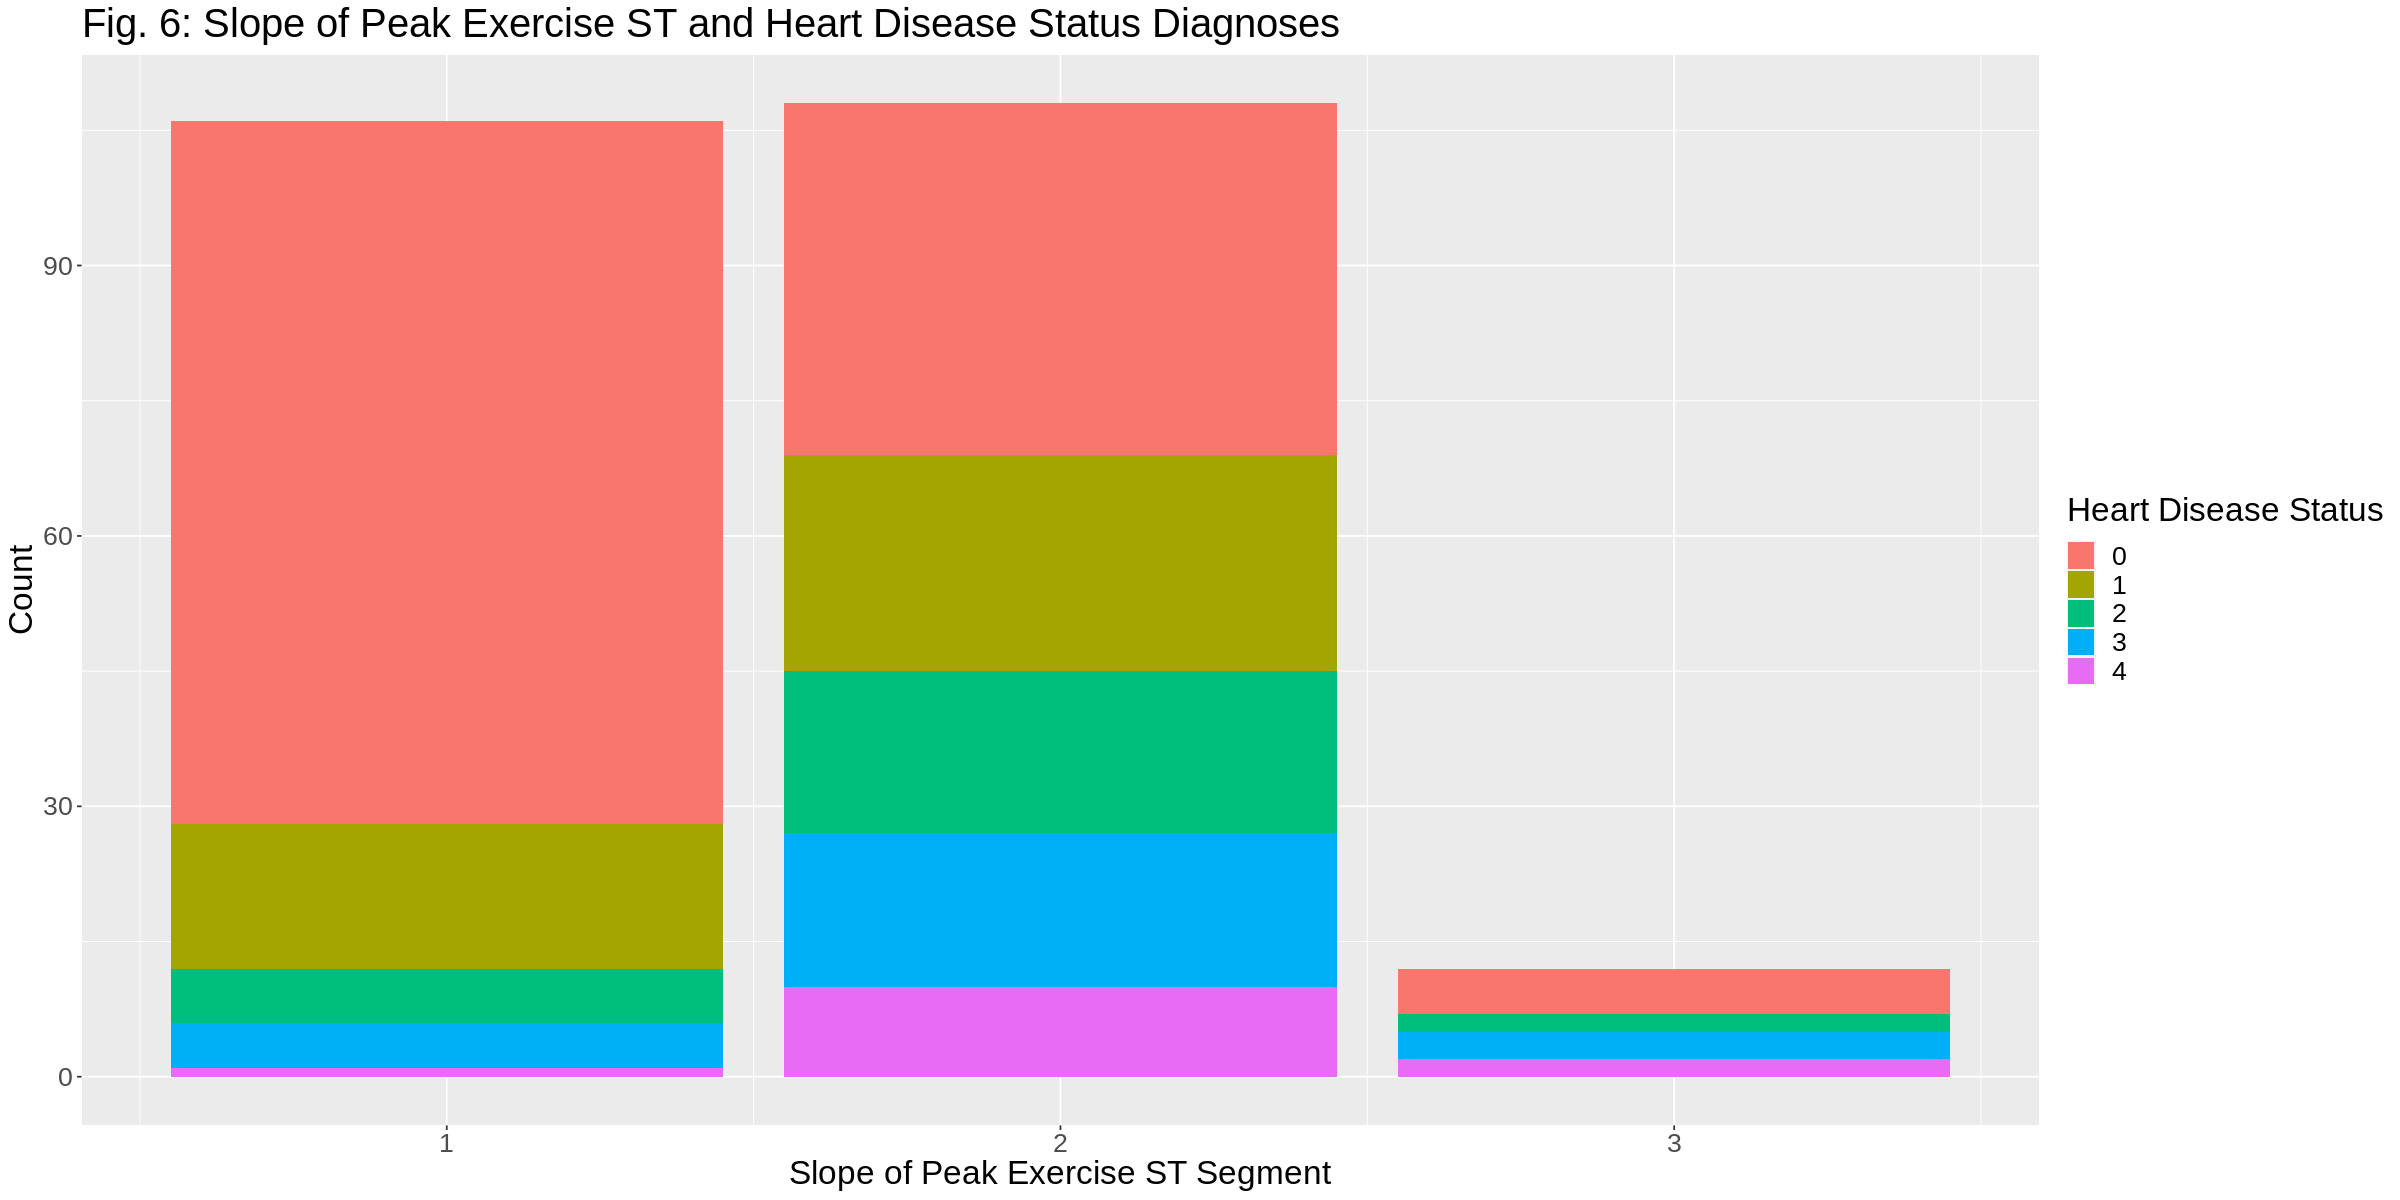

In [19]:
#Creating the plots to visualize the data in our second group of predictors in relation to the severity of heart disease. 
exercise_angina <- ggplot(exercise_train, aes(x = exercise_angina)) +
    ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_angina

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +

    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("ST Depression Induced By Exercise (Relative to Rest)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_st_plot

exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Slope of Peak Exercise ST and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Slope of Peak Exercise ST Segment") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_slope_plot

<b>References:</b>

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. British Journal of General Practice, 60(575), 246-257. 10.3399/bjgp10X502137

Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Harvard Health Publishing. (2021, September 21). Angina: Symptoms, diagnosis and treatments. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-andtreatments#:~:text=September%2021%2C%202021,by%20cholesterol%2Dclogged%20coronary%20arteries.

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. Heart. 90(12). 1417-1421. 10.1136/hrt.2003.031260

Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. PLoS ONE, 14(5), https://doi.org/10.1371/journal.pone.0216534

Timbers, T., Campbell, T., and Lee, M. (2022). Data Science: A First Introduction. 

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine (Baltimore). 94(47). 10.1097/MD.0000000000002160
